In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Bayesian estimate of $\mu$ and $\sigma$.

Let's go through some of the calculations in Gregory's Chapter 9 through a specific example.  There are three cases for estimating $\mu$ discussed in that chapter -- A) known noise $\sigma$ same for all $e_i$ (Section 9.2.1), B) known noise $\sigma_i$ unequal for all $e_i$ (Section 9.2.2), and C) unknown noise $\sigma$ same for all $e_i$ (Section 9.2.3).  Also discussed is a Bayesian estimate of $\sigma$ (Section 9.2.4) for Case C.

Let's implement Cases A and C.  Try to implement Case B yourself at home.

In [2]:
# set a seed so we always get same results
np.random.seed(12345)

mu  = 5.0   # parent population mean
sig = 2.0   # parent population standard deviation

n   = 10

# sample from Gaussian; compute sample mean, variance, and chi^2
d = np.random.normal(loc=mu, scale=sig, size=n)
smu   = np.mean(d)
sigmu = sig/np.sqrt(n)
chi2min = np.sum(((d-smu)/sig)**2)

# print summary
np.set_printoptions(formatter={'float': '{: 0.4f}'.format})
print("                Data  = ", d)
print("            MLE mean  = %8.4f" % smu)
print("   MLE error on mean  = %8.4f" % sigmu)
print(" minimum chi^2 value  = %8.4f" % chi2min)

                Data  =  [ 4.5906  5.9579  3.9611  3.8885  8.9316  7.7868  5.1858  5.5635  6.5380
  7.4929]
            MLE mean  =   5.9897
   MLE error on mean  =   0.6325
 minimum chi^2 value  =   6.4402


In [3]:
# upper and lower bounds for mu and sigma priors
muL  = 0.0
muH  = 10.0
sigL = 0.1
sigH = 6.0

# generate grid of mu and sigma values that extend beyond
# the non-zero prior ranges for plotting purposes
# we will use them throughout this notebook
mugrid  = np.linspace(0, 20, num=1001, endpoint=True)
siggrid = np.linspace(0.1, 10, num=1001, endpoint=True)

## Active learning exercise

1) define prior functions:

   `def priorUniform(mu, mumin=muL, mumax=muH):
      # your code goes here
      return prior`
      
      
   `def priorJeffreys(sig, sigmin=sigL, sigmax=sigH):
      # your code goes here
      return prior`
      
2) Plot priors.

In [4]:
def priorUniform(mu, mumin=muL, mumax=muH):
    # uniform prior
    prior = np.zeros_like(mu)+1.0/(mumax-mumin)
    # make sure to set prior outside range to zero
    prior[mu<mumin] = prior[mu>mumax] = 0.0
    return prior

In [5]:
def priorJeffreys(sig, sigmin=sigL, sigmax=sigH):
    # Jeffreys prior
    prior = 1.0/(sig*np.log(sigmax/sigmin))
    # make sure to set prior outside range to zero
    prior[sig<sigmin] = prior[sig>sigmax] = 0.0
    return prior

In [6]:
priormu = priorUniform(mugrid)
priorsig = priorJeffreys(siggrid)

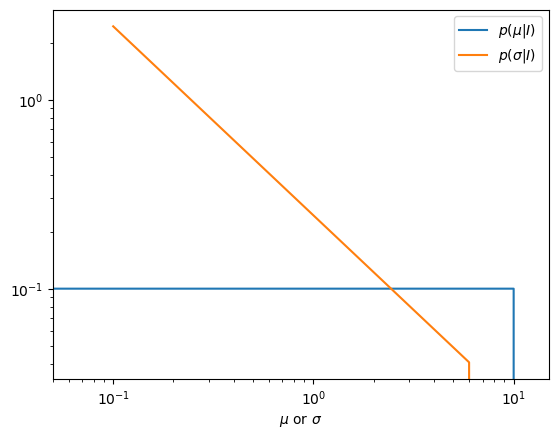

In [7]:
plt.plot(mugrid, priormu, label='$p(\mu|I)$')
plt.plot(siggrid, priorsig, label='$p(\sigma|I)$')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.05, 15])
plt.xlabel('$\mu$ or $\sigma$')
plt.legend()

In [8]:
# check prior normalization
print("   prior(mu) integral = ", np.trapz(priormu, mugrid))
print("prior(sigma) integral = ", np.trapz(priorsig, siggrid))
# If you want to be precise, you can divide the prior values
# by these normalization factors.  But it will have only a
# tiny effect.

   prior(mu) integral =  1.001
prior(sigma) integral =  1.0000140305235403


## Case A : $e_i = \sigma$, same for all $i$

The posterior is given by, $$p(\mu|D,I) = \frac{e^{-Q/(2\sigma^2)}}{\int_{\mu_L}^{\mu_H} e^{-Q/(2\sigma^2)}d\mu} = \frac{\mathrm{NUM}}{\mathrm{DEN}}$$ where $$Q = \sum_{i=1}^n (d_i-\mu)^2$$

The simplified form is Equation (9.8), $$p(\mu|D,I) = \frac{\mathrm{exp}\left\{-\frac{(\mu-\bar{d})^2}{2\sigma^2/N}\right\}}{\int_{\mu_L}^{\mu_H}\mathrm{exp}\left\{-\frac{(\mu-\bar{d})^2}{2\sigma^2/N}\right\}d\mu} = \frac{\mathrm{NUM}}{\mathrm{DEN}}$$ where $$\bar{d} = \frac{1}{N}\sum_{i=1}^{N} d_i$$

Let's implement both expressions; call them A1 and A2, respectively.  Keep in mind that NUM is zero outside the prior range.

## Active learning exercise

For A1:

1) Compute NUM, DEN, and posteriorA1 on `mugrid`

2) Plot posteriorA1 vs mugrid; label true $\mu$

In [9]:
NUM = np.zeros_like(mugrid)

# we are computing p(mu), so loop over mugrid values
for i in range(len(mugrid)):
    Q = np.sum((d - mugrid[i])**2)
    NUM[i] = np.exp(-Q/(2*sig*sig))
    
# make sure you multiply this by the prior
NUM = priormu*NUM

DEN = np.trapz(NUM, mugrid)
posteriorA1 = NUM/DEN

In [10]:
# check normalization; this should come out to exactly 1.0
print(np.trapz(posteriorA1, mugrid))

1.0


Text(4.7, 0.5, 'true $\\mu=5$')

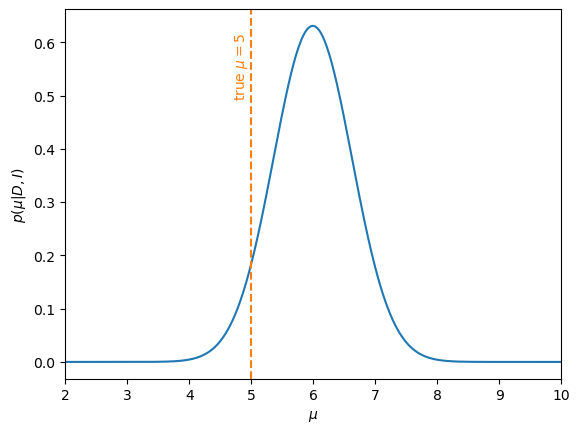

In [11]:
plt.plot(mugrid, posteriorA1)
# you can overplot the following to see that the posterior
# is a gaussian.
#plt.plot(mugrid, stats.norm.pdf(mugrid, loc=smu, scale=sigmu))
plt.xlim([2,10])
plt.xlabel('$\mu$')
plt.ylabel('$p(\mu|D,I)$')
plt.axvline(x=mu, ls='--', c='#ff7f0e')
plt.text(4.7, 0.5, 'true $\mu=5$', rotation=90, c='#ff7f0e')

This is the implementation of the second expression, which will of course yield the exact same results.

## Active learning exercise

For A2:

1) Compute NUM, DEN, and posteriorA2 on `mugrid`

2) Plot posteriorA2 vs mugrid; overplot posteriorA1; label true $\mu$

In [12]:
dbar = d.mean() # = smu
NUM = priormu*np.exp(-n*(mugrid-dbar)**2/(2*sig*sig))
DEN = np.trapz(NUM, mugrid)
posteriorA2 = NUM/DEN

In [13]:
# check normalization
print(np.trapz(posteriorA2, mugrid))

1.0


Text(4.7, 0.5, 'true $\\mu=5$')

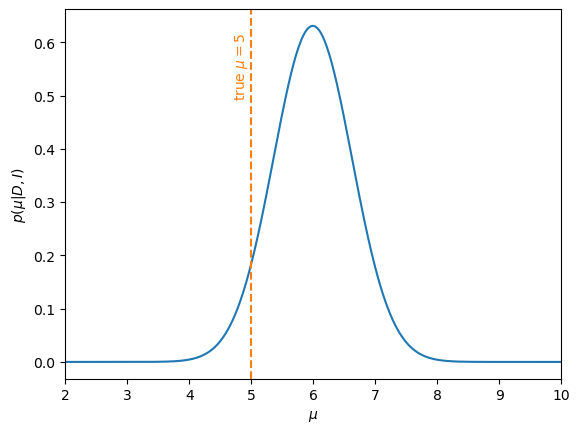

In [14]:
plt.plot(mugrid, posteriorA2)
plt.xlim([2,10])
plt.xlabel('$\mu$')
plt.ylabel('$p(\mu|D,I)$')
plt.axvline(x=mu, ls='--', c='#ff7f0e')
plt.text(4.7, 0.5, 'true $\mu=5$', rotation=90, c='#ff7f0e')

## Case B : $e_i = \sigma_i$, unequal for all $i$

The posterior is given by, $$p(\mu|D,I) = \frac{e^{-Q^\prime/2}}{\int_{\mu_L}^{\mu_H} e^{-Q^\prime/2} d\mu}$$ where $$Q^\prime = \sum_{i=1}^{N} \left(\frac{d_i-\mu}{\sigma_i}\right)^2$$

The posterior, after simplification, is given by Equation (9.19), $$p(\mu|D,I) = \frac{\mathrm{exp}\left\{-\frac{(\mu-\bar{d_w})^2}{2\sigma_w^2}\right\}}{\int_{\mu_L}^{\mu_H}\mathrm{exp}\left\{-\frac{(\mu-\bar{d_w})^2}{2\sigma_w^2}\right\}d\mu} = \frac{\mathrm{NUM}}{\mathrm{DEN}}$$ where $$\bar{d_w} = \frac{\sum_{i=1}^{N} w_i d_i}{\sum_{i=1}^{N} w_i}$$  $$\sigma_w^2 = \frac{1}{\sum_{i=1}^N w_i}$$ and $$w_i = \frac{1}{\sigma_i^2}$$  SEE IF YOU CAN IMPLEMENT THIS YOURSELF!

## NEXT - Case C